In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Gather Data

In [4]:
df_x = pd.read_csv('data/datasets/streamflow_prediction_dataset_averaged_cols.csv', index_col=0, parse_dates=True)
df_y = pd.read_csv('data/datasets/streamflow_prediction_dataset.csv', index_col=0, parse_dates=True)['streamflow']

df_x['Snow'] = np.where((df_x['WTEQ_BisonLake'] > 0) | (df_x['WTEQ_McClurePass'] > 0), 1, 0)

df_x = df_x.drop(
    columns=[
        'WTEQ_BisonLake', 'WTEQ_McClurePass', 'soilmoisture_Avg_2ft', 
        'soilmoisture_Avg_4ft', 'soilmoisture_Avg_20ft'
    ]
)

df = pd.concat([df_x, df_y], axis=1)

df.to_csv('data/datasets/snow_soilmoisture_prediction_dataset.csv')

display(df)

,PREC_Avg,TAVG_Avg,soilmoisture_Avg_8ft,Snow,streamflow
date,,,,,
2008-03-12,26.00,24.80,17.74,1,2360.0
2008-03-15,26.55,17.55,17.88,1,2260.0
2008-03-17,26.70,19.35,18.04,1,2260.0
2008-03-18,26.70,17.85,18.06,1,2260.0
2008-03-19,26.70,25.50,18.06,1,2200.0
...,...,...,...,...,...
2021-07-23,24.20,57.50,14.60,0,1170.0
2021-07-24,24.40,55.85,14.38,0,1240.0
2021-07-25,24.65,55.15,14.24,0,1190.0


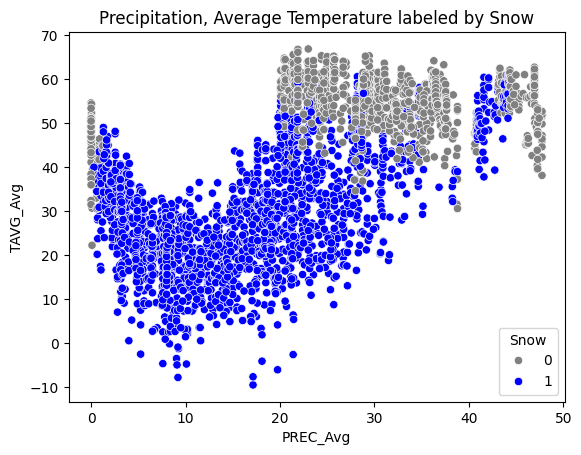

In [5]:
# visualize
palette={1: 'blue', 0: 'grey'}
sns.scatterplot(data=df, x='PREC_Avg', y='TAVG_Avg', hue='Snow', palette=palette)
plt.title('Precipitation, Average Temperature labeled by Snow')
plt.show()

# SVM - Snow

[[286  24]
 [ 68 521]]


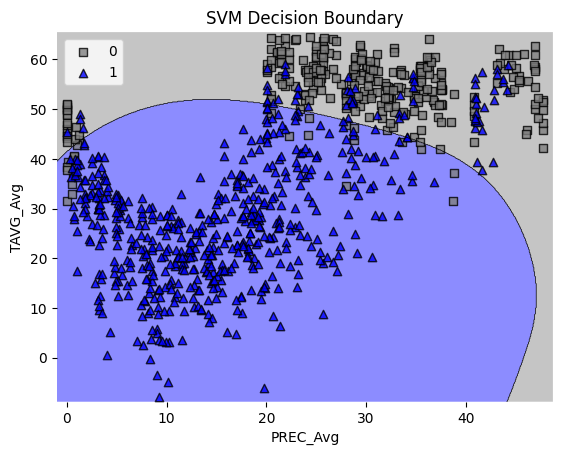

In [6]:
# default SVM to predict snow

X = df[['PREC_Avg', 'TAVG_Avg']]
y = df['Snow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

snow_svm = SVC()
snow_svm.fit(X_train, y_train)
predictions = snow_svm.predict(X_test)

print(confusion_matrix(y_test, predictions))

# visualize decision boundary
plot_decision_regions(X_test.values, y_test.values, clf=snow_svm, legend=2, colors='grey,blue')
plt.xlabel('PREC_Avg')
plt.ylabel('TAVG_Avg')
plt.title('SVM Decision Boundary')
plt.legend()
plt.show()

Kernel: linear, Cost: 0.1
[[266  48]
 [ 67 518]]


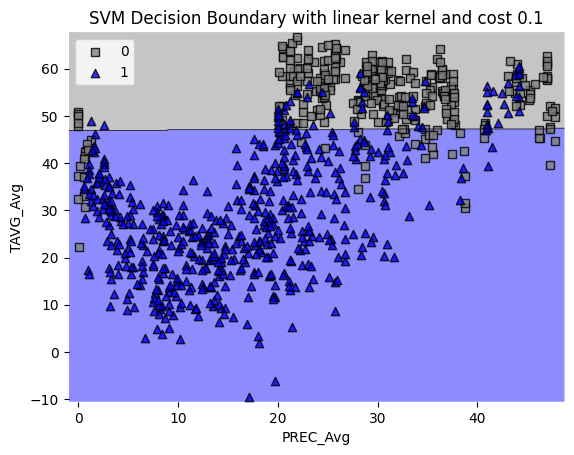

Kernel: linear, Cost: 1
[[266  48]
 [ 67 518]]


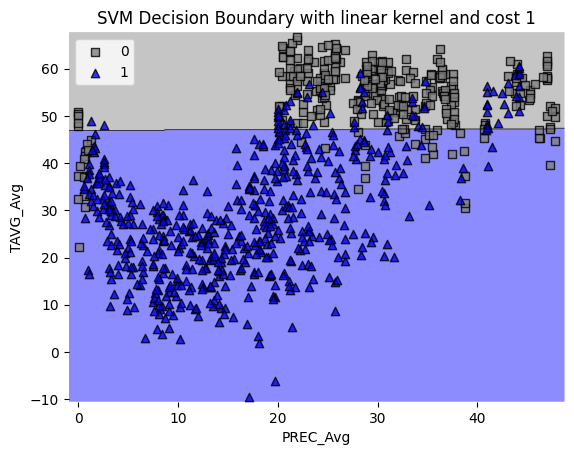

Kernel: linear, Cost: 10
[[265  49]
 [ 67 518]]


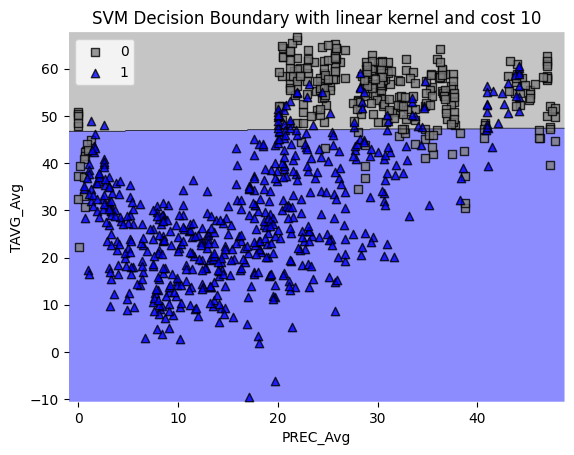

Kernel: poly, Cost: 0.1
[[266  48]
 [ 54 531]]


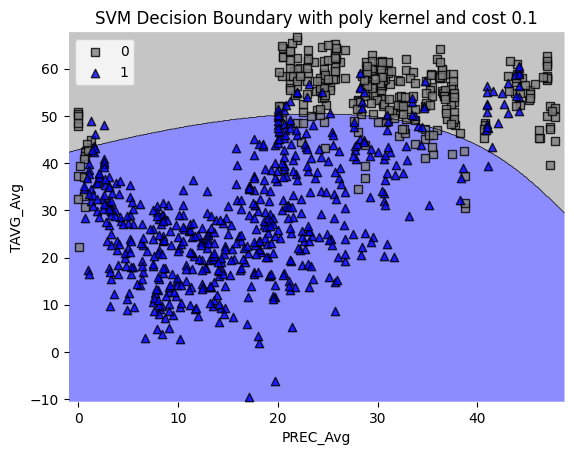

Kernel: poly, Cost: 1
[[266  48]
 [ 54 531]]


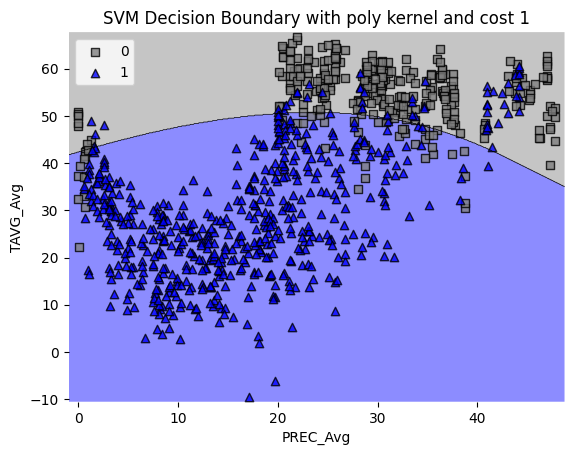

Kernel: poly, Cost: 10
[[267  47]
 [ 53 532]]


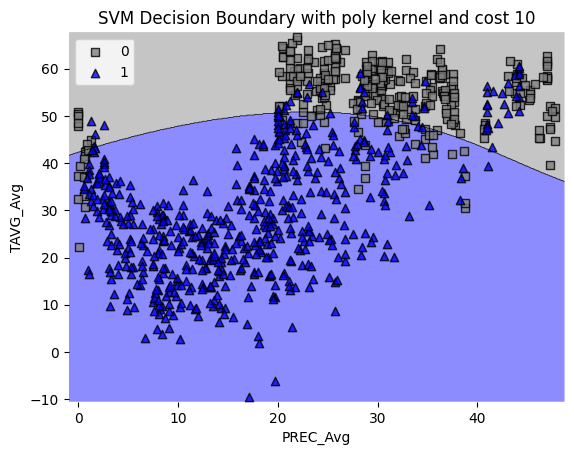

Kernel: rbf, Cost: 0.1
[[280  34]
 [ 62 523]]


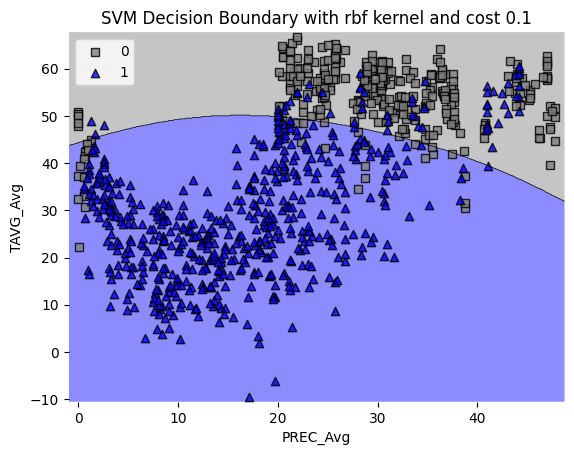

Kernel: rbf, Cost: 1
[[285  29]
 [ 59 526]]


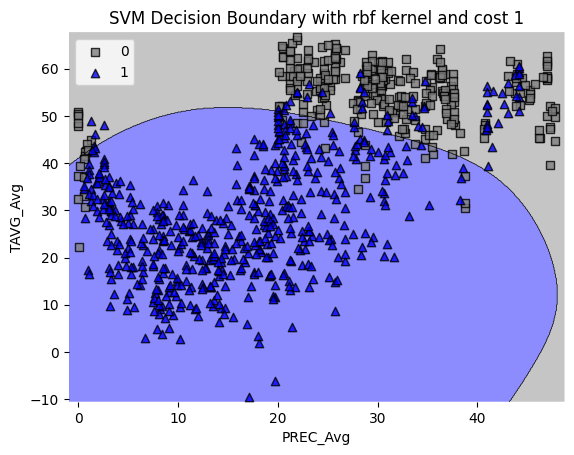

Kernel: rbf, Cost: 10
[[282  32]
 [ 56 529]]


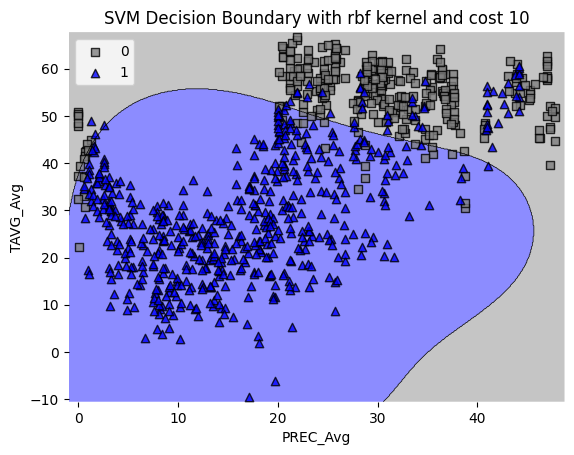

In [7]:
# SVM to predict snow with different kernels and costs

kernels = ['linear', 'poly', 'rbf']
costs = [0.1, 1, 10]
results = {}

X = df[['PREC_Avg', 'TAVG_Avg']]
y = df['Snow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

for kernel in kernels:
    for cost in costs:
        snow_svm = SVC(kernel=kernel, C=cost)
        snow_svm.fit(X_train, y_train)
        predictions = snow_svm.predict(X_test)
        
        cm = confusion_matrix(y_test, predictions)
        results[(kernel, cost)] = cm
        
        print(f'Kernel: {kernel}, Cost: {cost}')
        print(cm)
        
        # visualize decision boundary
        plot_decision_regions(X_test.values, y_test.values, clf=snow_svm, legend=2, colors='grey,blue')
        plt.xlabel('PREC_Avg')
        plt.ylabel('TAVG_Avg')
        plt.title(f'SVM Decision Boundary with {kernel} kernel and cost {cost}')
        plt.legend()
        plt.show()